In [2]:
# import hmmlearn as hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# GT_PATH = "./TestBench/GT.csv"
GT_PATH = '/Users/shawn/Documents/UMSI/Boeing Project/Inter_test/data/behavior_inter_rater_Shawn.csv'
GT = pd.read_csv(GT_PATH)
GT['Timestamp'] = pd.to_timedelta(GT['Timestamp'])

In [4]:
df = pd.DataFrame()

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, "..", "data", "PandasData", "Original")
files = os.listdir(data_directory)
files.sort()

for file in files:
    if file.endswith('pkl') and not file.__contains__('FAM'):
        cur_file = pd.read_pickle(os.path.join(data_directory, file))
        if file.__contains__('NSL'):
            cur_file['Condition'] = 'NSL'
        elif file.__contains__('SLD'):
            cur_file['Condition'] = 'SLD'
        else:
            assert('File name error!')
        PID = int(file[3:6])
        cur_file['PID'] = PID
        
        df = pd.concat([df, cur_file])

df.reset_index(drop=True, inplace=True)
df['AGV_name'] = df['AGV_name'].str[3:].astype(int)

df['Timestamp'] = pd.to_timedelta(df['Timestamp'])

In [5]:
try:
    df = df[['AGV_name', 'User_X', 'User_Y', 'AGV_X', 'AGV_Y', 'AGV_Pitch',
       'AGV_Yaw', 'AGV_Roll', 'AGV_speed', 'GazeOrigin_X', 'GazeOrigin_Y',
       'GazeDirection_X', 'GazeDirection_Y', 'GazeDirection_Z', 'Timestamp', 'PID','Condition']]
except:
    pass

In [6]:
merged = pd.merge(left=df, right=GT, on=['Timestamp', 'PID', 'AGV_name', 'Condition'], how='right')
merged.dropna(inplace=True)
merged.head()

,AGV_name,User_X,User_Y,AGV_X,AGV_Y,AGV_Pitch,AGV_Yaw,AGV_Roll,AGV_speed,GazeOrigin_X,GazeOrigin_Y,GazeDirection_X,GazeDirection_Y,GazeDirection_Z,Timestamp,PID,Condition,State
0,1,1601.017,8449.869,3700.000,11579.905,0.108297,-90.000000,0.000008,0.000000,1648.650,8588.159,0.007,0.295,-0.955,0 days 15:42:04,3,NSL,Start
1,1,1601.017,8449.869,3699.999,11579.890,0.126475,-89.999941,0.001722,0.000414,1648.651,8588.152,0.006,0.295,-0.956,0 days 15:42:04,3,NSL,Start
2,1,1601.017,8449.869,3699.998,11579.877,0.145197,-89.999955,0.002945,0.000440,1648.647,8588.145,0.004,0.294,-0.956,0 days 15:42:04,3,NSL,Start
3,1,1601.017,8449.869,3699.996,11579.857,0.177146,-89.999964,0.004570,-0.002751,1648.649,8588.134,0.004,0.293,-0.956,0 days 15:42:04,3,NSL,Start
4,1,1601.017,8449.869,3699.995,11579.839,0.208628,-89.999972,0.005880,-0.005558,1648.659,8588.113,0.004,0.292,-0.956,0 days 15:42:04,3,NSL,Start


In [7]:
def remove_redundant_arrived(df):
    '''
    Remove redundant Arrived state
    '''
    df = df.sort_values(by=['Timestamp'])
    total_arrived = df[df['State'] == 'Arrived'].shape[0]
    if total_arrived > 5:
        df = df.iloc[:-(total_arrived - 5)]
    return df


merged = merged.groupby(by = ['Condition', 'AGV_name', 'PID']).apply(remove_redundant_arrived).reset_index(drop=True)
print(f'data size: {merged.shape[0]}')

data size: 50239


In [9]:
AGV_name_list = merged['AGV_name'].unique()
PID_list = merged['PID'].unique()   
selected_AGV = np.random.randint(0, len(AGV_name_list), len(AGV_name_list)//2)
selected_PID = np.random.randint(0, len(PID_list), len(PID_list)//2)

selected_AGV = [ 0,  14,   8,   8,   4,   7,   1,  13]
selected_PID = [ 0,   5,  13,   9,  10,   3,   2,   2]

valid_set = merged[(merged['AGV_name'].isin(selected_AGV)) & (merged['PID'].isin(selected_PID))].copy()
train_set = merged[~(merged['AGV_name'].isin(selected_AGV)) | ~(merged['PID'].isin(selected_PID))].copy()

print(selected_AGV)
print(selected_PID)

[0, 14, 8, 8, 4, 7, 1, 13]
[0, 5, 13, 9, 10, 3, 2, 2]


In [10]:
try: 
    valid_set.drop(columns=['PID', 'Condition', 'AGV_name', 'Gaze ratio', 'TimestampID', \
                            'Timestamp', \
                            # 'facing_start_station', 'facing_end_station', 
                            # 'start_station_X', 
                            # 'start_station_Y', 'end_station_X', 'end_station_Y', 
                            # 'distance_from_start_station_X', 'distance_from_start_station_Y', 
                            # 'distance_from_end_station_X', 'distance_from_end_station_Y', \
                            # 'distance_to_closest_station', 'distance_to_closest_station_X','distance_to_closest_station_Y',
                            # 'GazeDirection_Z'
                            ], 
                            inplace=True, errors='ignore')
    
    train_set.drop(columns=['PID', 'Condition', 'AGV_name', 'Gaze ratio', 'TimestampID', \
                            'Timestamp', \
                            # 'facing_start_station', 'facing_end_station', 
                            # 'start_station_X', 
                            # 'start_station_Y', 'end_station_X', 'end_station_Y', 
                            # 'distance_from_start_station_X', 'distance_from_start_station_Y', 
                            # 'distance_from_end_station_X', 'distance_from_end_station_Y', \
                            # 'distance_to_closest_station', 'distance_to_closest_station_X','distance_to_closest_station_Y', 
                            # 'GazeDirection_Z'
                            ], 
                         inplace=True, errors='ignore')
except KeyError:
    print('KeyError')
    pass

train_set.columns


Index(['User_X', 'User_Y', 'AGV_X', 'AGV_Y', 'AGV_Pitch', 'AGV_Yaw',
       'AGV_Roll', 'AGV_speed', 'GazeOrigin_X', 'GazeOrigin_Y',
       'GazeDirection_X', 'GazeDirection_Y', 'GazeDirection_Z', 'State'],
      dtype='object')

In [11]:
print(valid_set.State.unique())

['Start' 'Approach Sidewalk' 'Wait' 'Cross' 'Approach Target Station'
 'Arrived' 'Move Along Sidewalk']


In [12]:
# Split data into train and test

# filter out error data 
valid_set = valid_set[valid_set['State'] != 'Error']
train_set = train_set[train_set['State'] != 'Error']

num_class = train_set['State'].nunique()

print(f'num of states: {train_set["State"].nunique()}')

train_X = train_set.drop(columns=['State'])
train_y = train_set['State']
test_X = valid_set.drop(columns=['State'])
test_y = valid_set['State']

num of states: 7


## XGBoost

In [13]:
from sklearn.model_selection import KFold
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime

In [14]:
# adapt to code
X_all= train_X
y_all = train_y

label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(y_all)

In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass', #'objective': #regression',
    'num_class': num_class,
    # 'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.05,
   # 'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0, #-1,
    'feature_pre_filter': False
}


X = np.array(X_all)
Y = np.array(y_all)

rmse_v = []
mae_v = []
Corr_v = []
Xdata = []
shap_values = []

startTime = datetime.now()
count = 0;
skf = KFold(n_splits=10, shuffle=True, random_state=0)


for train_index, test_index in skf.split(X,Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    Xdata.append(X_test)

    count = count + 1
    print(count)
    d_train = lgb.Dataset(X_train, y_train, feature_name=X_all.columns.tolist())
    d_valid = lgb.Dataset(X_test, y_test, reference=d_train, feature_name=X_all.columns.tolist())

    model = lgb.train(params, d_train, 5000, valid_sets=[d_valid],
                      callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(500)]) #verbose_eval=False, early_stopping_rounds=100)
    y_pred = model.predict(X_test)
            
    # rmse_v.append(np.sqrt(mean_squared_error(y_test, y_pred)))     
    # mae_v.append(mean_absolute_error(y_test, y_pred))    
    # Corr_v.append(np.corrcoef(y_test,y_pred))

    # explainer = shap.TreeExplainer(model, X_train)
    # shap_values.append(explainer.shap_values(X_test))
    print(datetime.now()-startTime)


1
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

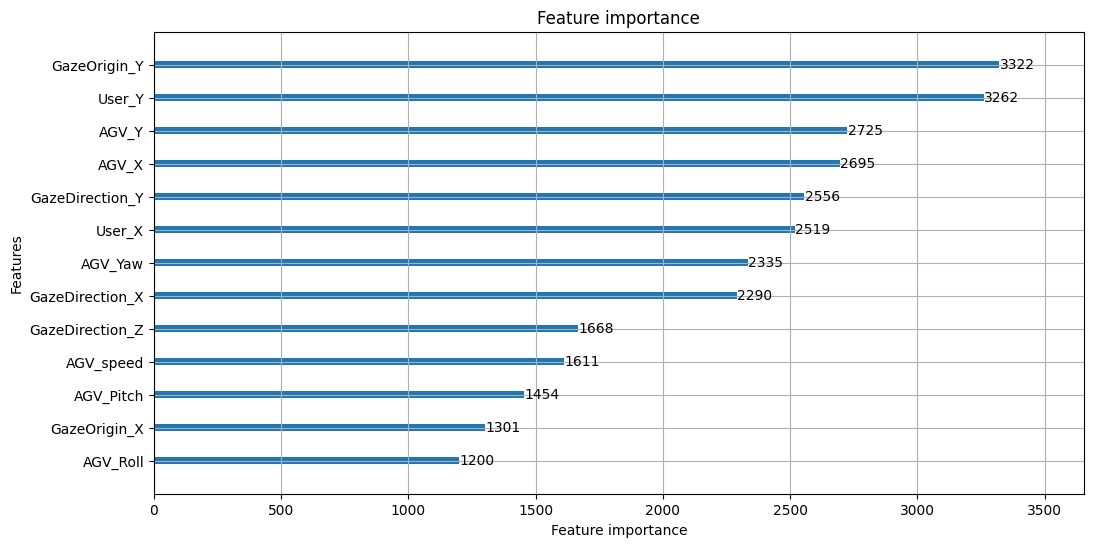

In [16]:
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

# Validation function

In [17]:
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)

y_pred = label_encoder.inverse_transform(y_pred)
accuracy = accuracy_score(test_y, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6732177734375


# Generate Test Dataframe

In [15]:
df_result = pd.DataFrame({'GT': test_y, 'Predicted': y_pred, 'Model': 'LGBM'})

## Other models

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [19]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

y_test_encoded = label_encoder.transform(test_y)

In [21]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(max_iter=2000)
}

param_distributions = {
    "Logistic Regression": {
        'C': uniform(0.1, 10),
        'penalty': ['l2']
    },
    "KNN": {
        'n_neighbors': randint(1, 50),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    "SVM": {
        'C': uniform(0.1, 10),
        'gamma': uniform(0.1, 1),
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    "Decision Tree": {
        'max_depth': randint(10, 100),
        'min_samples_split': uniform(0.1, 0.9),
        'min_samples_leaf': uniform(0.1, 0.5)
    },
    "Random Forest": {
        'n_estimators': randint(10, 200),
        'max_depth': randint(10, 100),
        'min_samples_split': uniform(0.1, 0.9),
        'min_samples_leaf': uniform(0.1, 0.5)
    },
    "Neural Network": {
        'hidden_layer_sizes': [(randint(10, 100).rvs(), randint(10, 100).rvs(),),
                               (randint(10, 100).rvs(),)],
        'alpha': uniform(0.0001, 0.005),
        'learning_rate_init': uniform(0.001, 0.01)
    }
}


In [23]:
# Random search with cross-validation
n_iter_search = 5  # Number of parameter settings that are sampled
cv_folds = 2        # Number of folds in cross-validation

best_models = {}

for model_name, param_dist in param_distributions.items():
    if model_name == "Logistic Regression":
        model = LogisticRegression()
    elif model_name == "KNN":
        model = KNeighborsClassifier()
    # elif model_name == "SVM":
    #     model = SVC()
    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier()
    elif model_name == "Random Forest":
        model = RandomForestClassifier()
    elif model_name == "Neural Network":
        model = MLPClassifier(max_iter=2000)
    else:
        continue

    print(f"Running Random Search for {model_name}")

    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=n_iter_search, cv=cv_folds, verbose=1, random_state=42)
    random_search.fit(train_X, train_y)
    best_models[model_name] = random_search.best_estimator_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")

Running Random Search for Logistic Regression
Fitting 2 folds for each of 5 candidates, totalling 10 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Best parameters for Logistic Regression: {'C': 1.6601864044243653, 'penalty': 'l2'}
Running Random Search for KNN
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 39, 'weights': 'distance'}
Running Random Search for Decision Tree
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters for Decision Tree: {'max_depth': 70, 'min_samples_leaf': 0.39842507897324353, 'min_samples_split': 0.501249477568232}
Running Random Search for Random Forest
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 0.17800932022121826, 'min_samples_split': 0.2403950683025824, 'n_estimators': 84}
Running Random Search for Neural Network
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters for Neural Network: {'alpha': 0.0019727005942368125, 'hidden_layer_sizes': (58, 41), 'learning_rate_init': 0.0028343478986616382}

- Best parameters for Logistic Regression: {'C': 9.60714306409916, 'penalty': 'l2'}
- Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 38, 'weights': 'distance'}

In [24]:
for model_name, model in best_models.items():
    
    accuracy = evaluate_model(model, train_X, train_y, test_X, test_y)
    print(f'{model_name} Accuracy: {accuracy}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression Accuracy: 0.1741943359375
KNN Accuracy: 0.3553466796875
Decision Tree Accuracy: 0.5224609375
Random Forest Accuracy: 0.4925537109375
Neural Network Accuracy: 0.3614501953125


### Adding other models except LGBM to the result_df

In [22]:
for name, model in models.items():
    model.fit(train_X, train_y)
    cur_df = pd.DataFrame({'GT': test_y, 'Predicted': model.predict(test_X), 'Model': name})
    df_result = pd.concat([df_result, cur_df])

    accuracy = evaluate_model(model, train_X, train_y, test_X, test_y)
    print(f'{name} Accuracy: {accuracy}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression Accuracy: 0.4105504587155963
KNN Accuracy: 0.32339449541284404
SVM Accuracy: 0.28440366972477066
Decision Tree Accuracy: 0.5756880733944955
Random Forest Accuracy: 0.7614678899082569
Neural Network Accuracy: 0.24770642201834864


In [23]:
ours = pd.read_csv('/Users/shawn/Documents/UMSI/Boeing Project/Inter_test/data/result_ourmodel.csv')

try:
    ours.rename(columns={'state' : 'Predicted'}, inplace=True)
    ours.rename(columns={'model' : 'Model'}, inplace=True)
except: pass
ours['Model'] = 'Ours'
df_result = pd.concat([ours, df_result])

In [24]:
df_result

,Timestamp,GT,AGV distance X,AGV distance Y,AGV speed X,AGV speed Y,AGV speed,User speed X,User speed Y,User speed,...,User_Y,AGV_name,TimestampID,looking_at_closest_station,Gaze ratio,Predicted,result,PID,AGV_type,Model
0,0 days 15:42:04,At Station,20.989831,31.151637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8449.869000,AGV1,1.0,False,0.0,Error,False,3.0,NSL,Ours
1,0 days 15:42:05,At Station,20.976235,29.912665,0.000132,1.247179,1.247179,0.013727,0.008206,0.015993,...,8449.048375,AGV1,2.0,False,0.0,At Station,True,3.0,NSL,Ours
2,0 days 15:42:06,At Station,20.928714,26.936140,0.000362,3.078101,3.078101,0.047883,0.101576,0.112297,...,8438.890763,AGV1,3.0,False,0.0,At Station,True,3.0,NSL,Ours
3,0 days 15:42:07,At Station,20.787325,22.331867,0.000967,4.633172,4.633172,0.142357,0.028899,0.145260,...,8436.000819,AGV1,4.0,False,0.0,At Station,True,3.0,NSL,Ours
4,0 days 15:42:08,At Station,20.610721,16.055885,0.000273,6.473817,6.473817,0.176330,0.197834,0.265011,...,8416.217375,AGV1,5.0,False,0.0,At Station,True,3.0,NSL,Ours
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,NaN,Arrived,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Move Along Sidewalk,NaN,NaN,NaN,Neural Network
790,NaN,Arrived,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Move Along Sidewalk,NaN,NaN,NaN,Neural Network
791,NaN,Arrived,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Move Along Sidewalk,NaN,NaN,NaN,Neural Network
792,NaN,Arrived,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Move Along Sidewalk,NaN,NaN,NaN,Neural Network


In [25]:
df_result.replace('Arrived', 'At Station', inplace=True)
df_result.replace('Start', 'At Station', inplace=True)
df_result = df_result[df_result['GT'] != 'Error']
df_result = df_result[df_result['Predicted'] != 'Error']

Ignoring `palette` because no `hue` variable has been assigned.


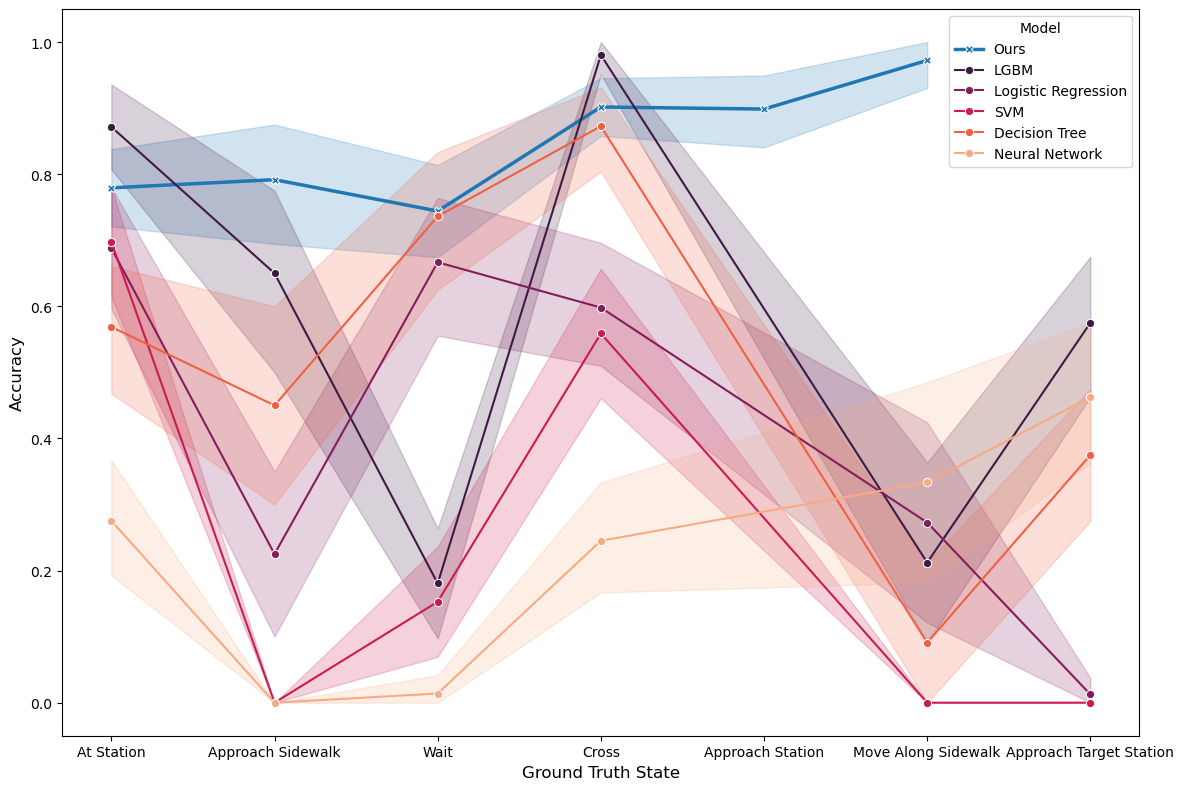

In [26]:
selected_models = ['Logistic Regression', 'SVM', 'Decision Tree', "Neural Network", 'LGBM', 'Ours']


def calculate_accuracy(row):
    return row['Predicted'] == row['GT']
# Apply the function to create a new 'Correct' column
df = df_result.copy()
df['Accuracy'] = df.apply(calculate_accuracy, axis=1)
df = df[df['Model'].isin(selected_models)]

# Plot all models with a standard line
plt.figure(figsize=(12, 8))

sns.lineplot(data=df[df['Model']=='Ours'], x='GT', y='Accuracy',marker='X', palette="rocket", linewidth=2.5, label='Ours')
sns.lineplot(data=df[df['Model']!='Ours'], x='GT', y='Accuracy', hue='Model', marker='o', palette="rocket")

plt.tight_layout()
# plt.title('Model Accuracy by States')
plt.xlabel('Ground Truth State', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
# plt.legend(title='Model')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # This removes duplicates
plt.legend(by_label.values(), by_label.keys(), title='Model')

plt.savefig('./Figures/model_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


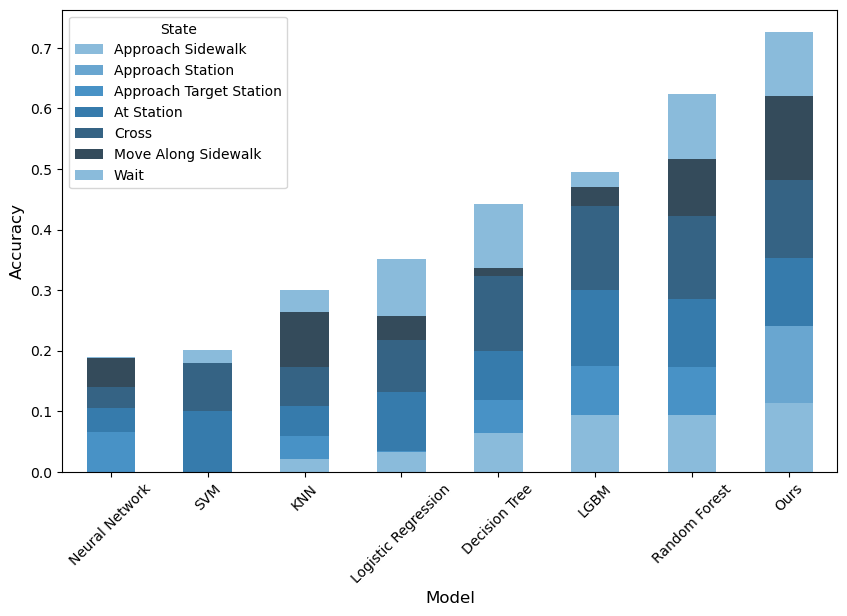

In [27]:
df = df_result.copy()
df['Accuracy'] = df.apply(calculate_accuracy, axis=1)

compare_df = df[['GT', 'Predicted', 'Model']]
compare_df['Correct'] = compare_df['GT'] == compare_df['Predicted']
pivot = compare_df.pivot_table(index='Model', columns='GT', values = 'Correct', fill_value=0)
# pivot_GT = compare_df.pivot_table(index='Model', columns='GT', values = 'Predicted', aggfunc='count', fill_value=0)
pivot = pivot.apply(lambda x: x / compare_df['GT'].nunique())
pivot['sum'] = pivot.sum(axis=1)
pivot = pivot.sort_values(by='sum')
pivot.drop(columns=['sum'], inplace=True)
# # Create a stacked bar plot

pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=sns.color_palette('Blues_d', 6))
# plt.tight_layout()
plt.xticks(rotation=45)
# plt.title('Comparison of Model Accuracy by States')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='State')
plt.savefig('./Figures/model_accuracy.png', dpi=300, bbox_inches='tight')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


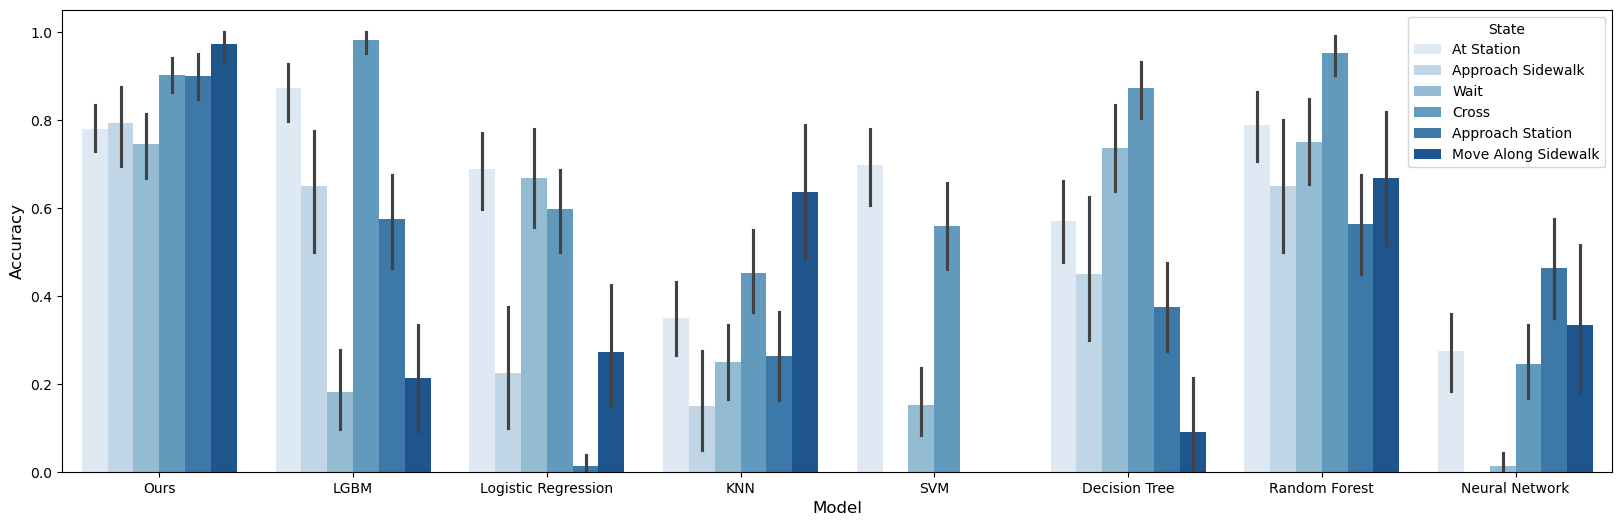

In [28]:
df = df_result.copy()
df = df.replace('Approach Target Station', 'Approach Station')
df['Accuracy'] = df.apply(calculate_accuracy, axis=1)


compare_df = df[['GT', 'Predicted', 'Model']]
compare_df['Correct'] = compare_df['GT'] == compare_df['Predicted']

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=compare_df, x='Model', y='Correct', hue='GT', palette='Blues')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='State')
plt.savefig('./Figures/model_accuracy.png', dpi=300, bbox_inches='tight')

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Sample DataFrame loading (replace with your actual DataFrame)
# df = pd.DataFrame(data)

# Ensure your GT and predicted columns are properly encoded if they are categorical
le = LabelEncoder()

df = df_result.copy()

df.dropna(subset=['GT', 'Predicted', 'Model'], inplace=True)

df['GT_encoded'] = le.fit_transform(df['GT'])
df['predicted_encoded'] = le.transform(df['Predicted'])

models = df['Model'].unique()
results = []

for model in models:
    model_data = df[df['Model'] == model]
    gt = model_data['GT_encoded']
    pred = model_data['predicted_encoded']
    
    accuracy = accuracy_score(gt, pred)
    precision_macro = precision_score(gt, pred, average='macro')
    recall_macro = recall_score(gt, pred, average='macro')
    f1_macro = f1_score(gt, pred, average='macro')
    precision_micro = precision_score(gt, pred, average='micro')
    recall_micro = recall_score(gt, pred, average='micro')
    f1_micro = f1_score(gt, pred, average='micro')
    # Confusion Matrix and Classification Report for detailed analysis

    results.append({
        'model': model,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
    })

# Convert results to a DataFrame for easier comparison
results_df = pd.DataFrame(results)

print(results_df[['model', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']])
# For detailed classification report or confusion matrix, access the 'results' list or expand the print statement.

                 model  accuracy  precision_macro  recall_macro  f1_macro
0                 Ours  0.839461         0.820116      0.847924  0.826892
1                 LGBM  0.658257         0.606175      0.578271  0.563426
2  Logistic Regression  0.465596         0.391713      0.410501  0.382480
3                  KNN  0.344037         0.336797      0.349745  0.339570
4                  SVM  0.330275         0.148570      0.234808  0.178024
5        Decision Tree  0.584862         0.527239      0.515563  0.507160
6        Random Forest  0.756881         0.732832      0.728190  0.727220
7       Neural Network  0.238532         0.206571      0.221675  0.192099


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [30]:
results_df[results_df['model'] != 'Random Forest'].sort_values(by='accuracy')\
        .to_csv('./Figures/model_performance.csv')

In [31]:
results_df

,model,accuracy,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
0,Ours,0.839461,0.820116,0.847924,0.826892,0.839461,0.839461,0.839461
1,LGBM,0.658257,0.606175,0.578271,0.563426,0.658257,0.658257,0.658257
2,Logistic Regression,0.465596,0.391713,0.410501,0.382480,0.465596,0.465596,0.465596
3,KNN,0.344037,0.336797,0.349745,0.339570,0.344037,0.344037,0.344037
4,SVM,0.330275,0.148570,0.234808,0.178024,0.330275,0.330275,0.330275
5,Decision Tree,0.584862,0.527239,0.515563,0.507160,0.584862,0.584862,0.584862
6,Random Forest,0.756881,0.732832,0.728190,0.727220,0.756881,0.756881,0.756881
7,Neural Network,0.238532,0.206571,0.221675,0.192099,0.238532,0.238532,0.238532


In [32]:
df = pd.read_csv('/Users/shawn/Documents/UMSI/Boeing Project/Inter_test/data/result_ourmodel.csv', index_col=0)
df.replace('Arrived', 'At Station', inplace=True)
df.replace('Start', 'At Station', inplace=True)

df.rename(columns={'state': 'Predicted'}, inplace=True)
df = df[df['GT'] != 'Error']
df = df[df['Predicted'] != 'Error']

# Initialize a LabelEncoder and fit it to all possible classes (both GT and Predicted)
le = LabelEncoder()
le.fit(pd.concat([df['GT'], df['Predicted']]))

# Encode GT and Predicted columns
df['GT_encoded'] = le.transform(df['GT'])
df['Predicted_encoded'] = le.transform(df['Predicted'])

# Initialize a list to store our metrics for each GT state
metrics_list = []

# Loop through each GT state
for gt_state in df['GT'].unique():
    # Filter the DataFrame for the current GT state
    subset_df = df[df['GT'] == gt_state]
    
    # Calculate metrics
    precision_macro = precision_score(subset_df['GT_encoded'], subset_df['Predicted_encoded'], average='macro')
    accuracy = accuracy_score(subset_df['GT_encoded'], subset_df['Predicted_encoded'])
    f1 = f1_score(subset_df['GT_encoded'], subset_df['Predicted_encoded'], average='weighted')
    recall = recall_score(subset_df['GT_encoded'], subset_df['Predicted_encoded'], average='weighted')
    
    # Append the metrics to our list
    metrics_list.append({'GT State': gt_state, 'Accuracy': accuracy, 'Precision' : precision_macro, 'Recall': recall, 'F1 Score': f1})

# Convert the list of metrics to a DataFrame for easy viewing
metrics_df = pd.DataFrame(metrics_list)

metrics_df.sort_values(by='Accuracy', ascending=False).set_index('GT State').to_csv('./Figures/our_model_performance.csv')
metrics_df.sort_values(by='Accuracy', ascending=False)

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


,GT State,Accuracy,Precision,Recall,F1 Score
5,Move Along Sidewalk,0.972222,0.333333,0.972222,0.985915
3,Cross,0.901639,0.200000,0.901639,0.948276
4,Approach Station,0.898551,0.333333,0.898551,0.946565
1,Approach Sidewalk,0.791667,0.200000,0.791667,0.883721
0,At Station,0.779279,0.250000,0.779279,0.875949
2,Wait,0.744186,0.200000,0.744186,0.853333
